# 4. Homework MLZoomcamp

## Dataset

This homework use Credit Card Data from book "Econometric Analysis" the link to database is:

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

The goal of the homework is to inspect the output of different evaluation metrics by creating a classification model (target column card)

## Preparation

- Create the target variable by mapping yes to 1 and no to 0
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('credit_card_data.csv')

In [4]:
df.card = (df.card == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is <0.5, invert this variable by putting "-" in front

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable, then becomes positive.

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [7]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [8]:
numerical = ['reports', 'age', 'income', 'share', 
             'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [9]:
for c in ['reports', 'dependents', 'active', 'share']:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%11s, %.3f' % (c,auc))

    reports, 0.717
 dependents, 0.533
     active, 0.604
      share, 0.989


## Training the model

Fron now on, use these columns only:

In [10]:
feature = ["reports", "age", "income", "share", "expenditure", 
           "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [12]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[feature].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? 

In [13]:
val_dict = df_val[feature].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
auc_2 = roc_auc_score(y_val, y_pred)
round(auc_2, 3)

0.995

## Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [14]:
import matplotlib.pyplot as plt

In [15]:
thresholds = np.linspace(0, 1, 101)

prec = []
rec =[]

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    prec.append(p)
    rec.append(r)
    scores.append((t, tp, fp, fn, tn, p, r))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'P', 'R']
df_scores = pd.DataFrame(scores, columns=columns)

In [16]:
df_scores[::10]

,threshold,tp,fp,fn,tn,P,R
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,1,36,0.925110,0.995261
20,0.2,207,5,4,48,0.976415,0.981043
30,0.3,205,5,6,48,0.976190,0.971564
40,0.4,205,1,6,52,0.995146,0.971564
50,0.5,204,1,7,52,0.995122,0.966825
60,0.6,204,1,7,52,0.995122,0.966825
70,0.7,204,1,7,52,0.995122,0.966825
80,0.8,204,1,7,52,0.995122,0.966825
90,0.9,204,0,7,53,1.000000,0.966825


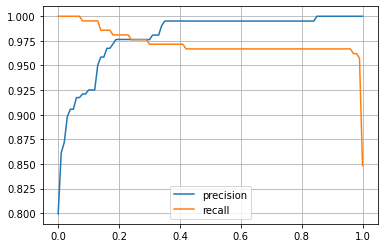

In [17]:
plt.plot(df_scores.threshold, df_scores.P, label='precision')
plt.plot(df_scores.threshold, df_scores.R, label='recall')
plt.legend(loc='lower center')
plt.grid(True)

## Question 4

Precision and recall are conflicting- when one growns, the other goes down. That's why they are often combined into the F1 score - a metric that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

In [18]:
df_scores['f1'] = ((2) * (df_scores.P) * (df_scores.R))  / (df_scores.P + df_scores.R)

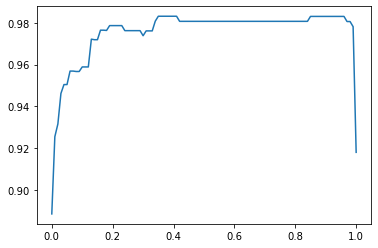

In [19]:
plt.plot(df_scores.threshold, df_scores.f1)

In [20]:
ans = [10, 40,  60, 70]
df_scores.iloc[ans]

,threshold,tp,fp,fn,tn,P,R,f1
10,0.1,210,17,1,36,0.925110,0.995261,0.958904
40,0.4,205,1,6,52,0.995146,0.971564,0.983213
60,0.6,204,1,7,52,0.995122,0.966825,0.980769
70,0.7,204,1,7,52,0.995122,0.966825,0.980769


## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds

KFold(n_splits = 5, shuffle = True, random_state = 1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the AUC scores across different folds?

In [21]:
from sklearn.model_selection import KFold

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    auc_scores.append(auc)
    
round(np.std(auc_scores), 3)

0.003

## Question 6

Now let's use 5-fold cross validation to fin the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits

Which C leads to the best mean score?

In [25]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)

        auc_scores.append(auc)

    print('C=%s, %.3f +- %.3f' % (C, np.mean(auc_scores), np.std(auc_scores)))

C=0.01, 0.992 +- 0.006
C=0.1, 0.995 +- 0.004
C=1, 0.996 +- 0.003
C=10, 0.996 +- 0.003


If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.